# Experiments with the diversity condition violated

In this notebook I will perform the SimCLR experiments where the diversity condition was violated. Mathematically it essentially means that we will use the following distributions for sampling:

- $p(z) = \frac{1}{|\mathcal{Z}|}$ - Marginal distribution is simply a uniform distribution on a sphere
- $p(\tilde{z}|z) = \delta(u-u') \frac{e^{\kappa \tilde{z}^{T}z}}{\int_{W}e^{\kappa v^{T}v' dv}}$

Where the latent space can be decomposed into 2 components $z = (u,v)^{T}$ where $u \in R^{n}$, $v \in R^{m}$, and $m + n = d$ - the dimension of the latent space.

I will primarily work with hyper-spheres as my latent space, hence the condition $z^{2} = u^{2} + v^{2} = 1$ will be enforced.

Experiment with these data-generating processes:

- Identity ✅
- Linear Mapping (to 4D, 5D, 6D, 7D) ✅
- Spirals ✅
- Patches ✅
- Injective Neural Network as a data generating process ✅

For now fix one dimension (the first one):

Consider later:

- Fix multiple dimensions
- Fix dimensions randomly


Additionally, we want to take an orthogonal transformation and check that the loss in our sampling experiment is higher than the loss we have achieved by directly optimizing the neural network $f$

In [11]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))

import torch
from torch import nn
from torch import functional
from simclr.simclr import SimCLR
from encoders import get_mlp
import matplotlib.pyplot as plt
from spaces import NSphereSpace
from visualization_utils.spheres import visualize_spheres_side_by_side

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 6144
tau = 0.3
kappa = 1 / tau
iterations = 10000
latent_dim = 3

fixed_dims_on_sample = 1

full_sphere = NSphereSpace(3)
sub_sphere = NSphereSpace(2)


def sample_conditional_with_dims_fixed(z, batch, u_dim):
    u = z[:,:u_dim]
    v = z[:,u_dim:]

    v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
    aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch) * torch.norm(v, p=2, dim=-1, keepdim=True)

    return torch.cat((u, aug_samples_v), dim=-1)


def sample_pair_with_fixed_dimension(batch, u_dim):
    z = full_sphere.uniform(batch) # (N, 3)
    
    return z, sample_conditional_with_dims_fixed(z, batch, u_dim)

sample_uniform_fixed = lambda batch: full_sphere.uniform(batch)
sample_pair_fixed = lambda batch: sample_pair_with_fixed_dimension(batch, fixed_dims_on_sample)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualizing the constrained sampling procedure

Below you can see how samples from the constrained sampling distribution look like

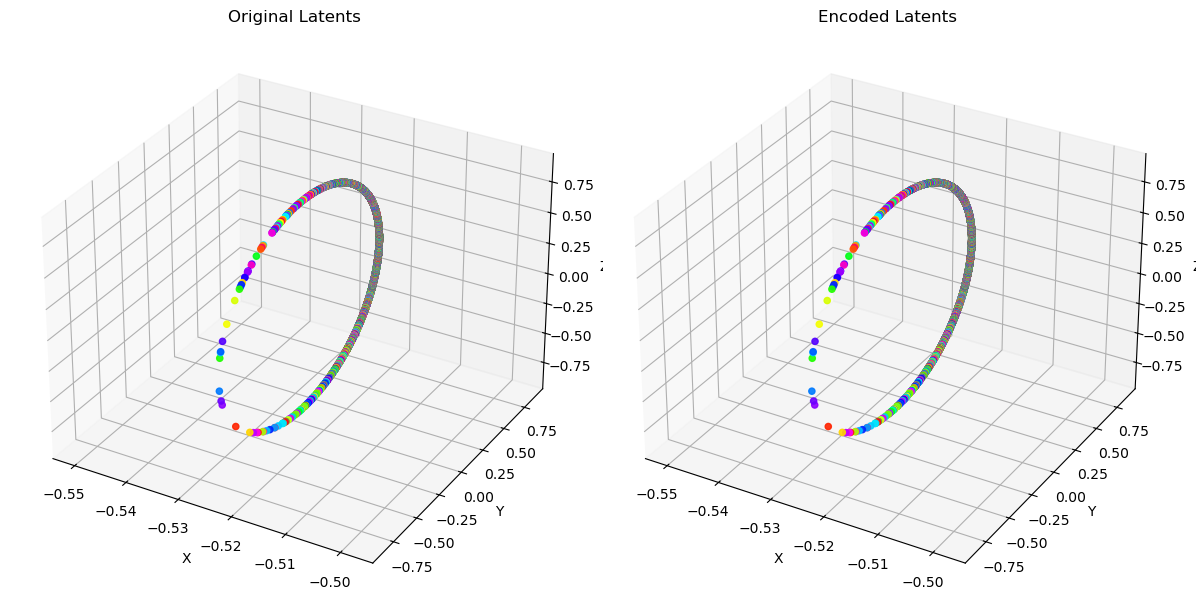

In [12]:
z = sample_uniform_fixed(1).squeeze(0)

u = z[:1]
v = z[1:]

v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch_size) * torch.norm(v, p=2, dim=-1, keepdim=True)

z_aug = torch.cat((u.expand(batch_size, 1), aug_samples_v), dim=-1)

visualize_spheres_side_by_side(plt, z_aug, z_aug)

## Training the identity generating process

$g(z) = z$

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.682066917419434 Samples processed: 1 linear disentanglement: 0.8875275254249573 permutation disentanglement: 0.1690605729818344 angle_preservation_error: 0.18708211183547974
Loss: 7.654505729675293 Samples processed: 21 linear disentanglement: 0.8901370167732239 permutation disentanglement: 0.16956152021884918 angle_preservation_error: 0.1851952224969864
Loss: 7.650476455688477 Samples processed: 41 linear disentanglement: 0.890594482421875 permutation disentanglement: 0.18157075345516205 angle_preservation_error: 0.18534456193447113
Loss: 7.623673439025879 Samples processed: 61 linear disentanglement: 0.8921834826469421 permutation disentanglement: 0.17318759858608246 angle_preservation_error: 0.18397068977355957
Loss: 7.6528120040893555 Samples processed: 81 linear disentanglement: 0.8924350738525391 permutation disentanglement: 0.16077446937561035 angle_preservation_error: 0.1836889088153839
Loss: 7.620425701141357 Sam

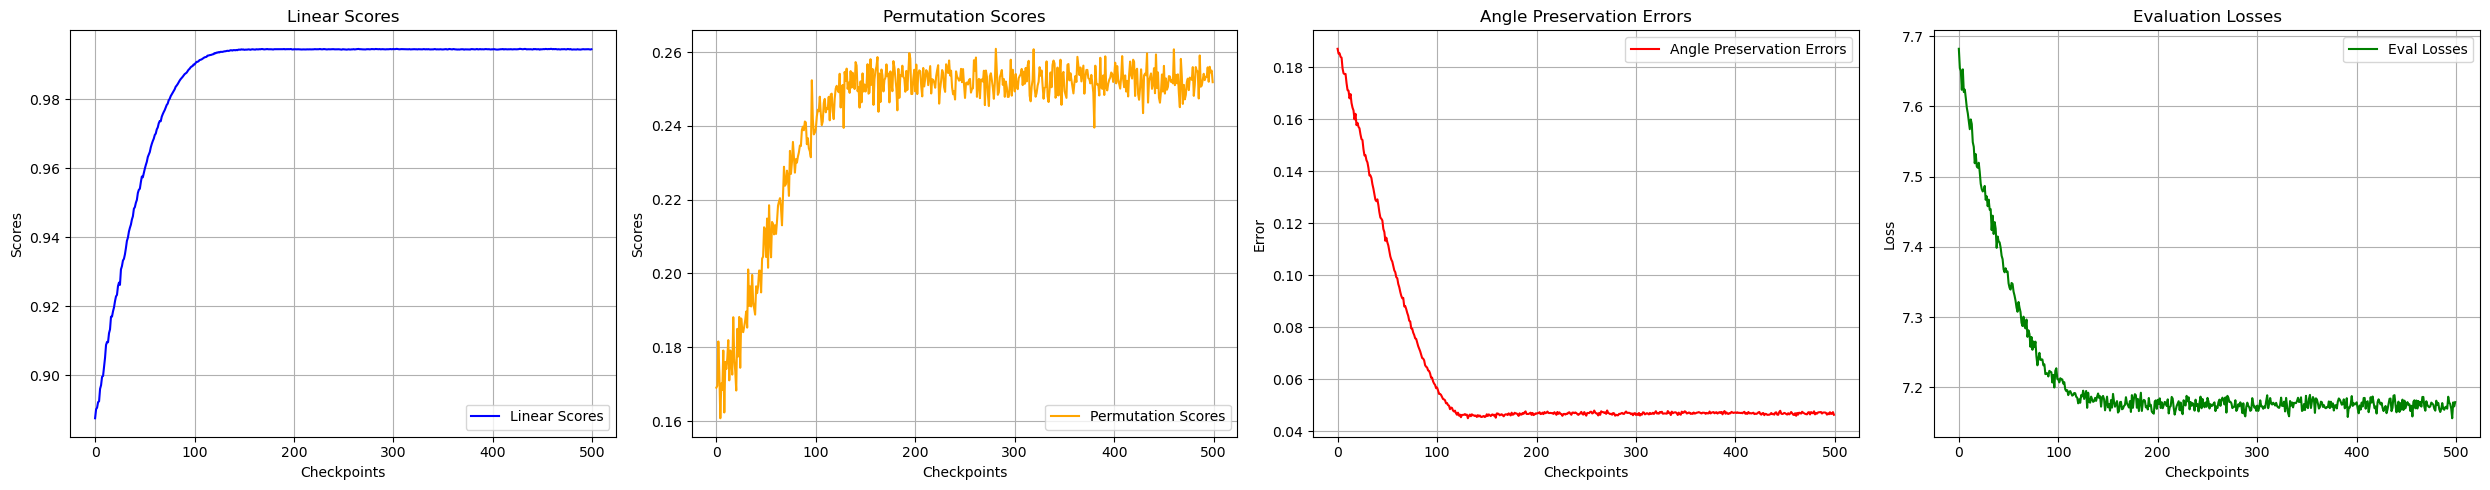

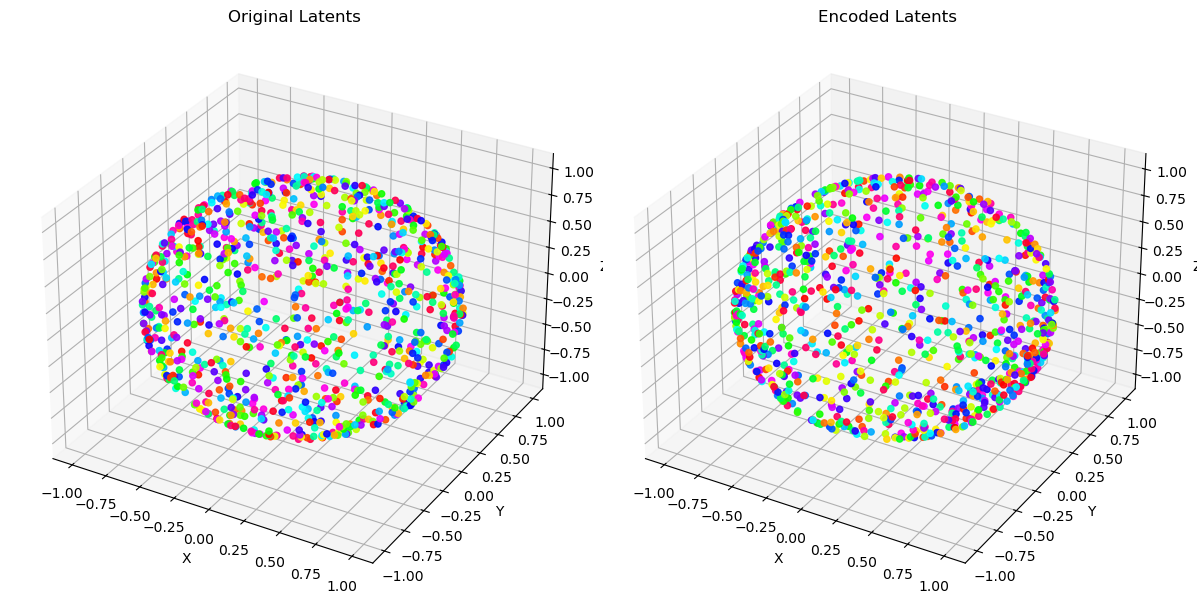

In [13]:
from visualization_utils.scoring import plot_scores
from visualization_utils.spheres import scatter3d_sphere

class LinearEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearEncoder, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return torch.nn.functional.normalize(self.fc(x), dim=-1, p=2)


f_constrained = LinearEncoder(3, 3)

g_id = nn.Identity()

simclr_id = SimCLR(
    f_constrained, g_id, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_constrained, scores = simclr_id.train(batch_size, iterations)

plot_scores(plt, scores)

h_constrained = lambda z: f_constrained(g_id(z))

z = full_sphere.uniform(1000).to(device)
z_enc = h_constrained(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

In [19]:
def compute_orthogonal_transformation_loss(sample_pair):
    z, z_aug = sample_pair(batch_size)

    # (N, N, 3)
    # Sample uniformally from the sphere
    z_neg = torch.nn.functional.normalize(
        torch.randn((batch_size, batch_size, latent_dim), device=z.device), p=2, dim=-1)

    pos = - torch.sum(z * z_aug, dim=-1).mean() / tau
    
    # (N, 1, 3) * (N, N, 3) -> (N, N, 3)
    neg = torch.log(torch.exp((z.unsqueeze(1) * z_neg).sum(dim=-1) / tau).sum(-1)).mean()

    return (pos + neg).item()

orthogonal_loss = compute_orthogonal_transformation_loss(sample_pair_fixed)

print("Orthogonal transformation loss: ", orthogonal_loss)
print("Training loss: ", scores['eval_losses'][-1])


Orthogonal transformation loss:  7.193957805633545
Training loss:  7.178922653198242


## Linear map generating process

$g(z) = Az$, where $A \in \mathbb{R}^{k \times 3}$ and $k \in \{4,5,6,7\}$ and $rank(A) = 3$

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.482206344604492 Samples processed: 1 linear disentanglement: 0.6659692525863647 permutation disentanglement: 0.04275091364979744 angle_preservation_error: 0.4457472264766693
Loss: 8.478239059448242 Samples processed: 21 linear disentanglement: 0.6611137986183167 permutation disentanglement: 0.04788042977452278 angle_preservation_error: 0.44442814588546753
Loss: 8.466720581054688 Samples processed: 41 linear disentanglement: 0.6658390164375305 permutation disentanglement: 0.04631827399134636 angle_preservation_error: 0.4424121677875519
Loss: 8.45910930633545 Samples processed: 61 linear disentanglement: 0.6655410528182983 permutation disentanglement: 0.051069896668195724 angle_preservation_error: 0.43959587812423706
Loss: 8.458301544189453 Samples processed: 81 linear disentanglement: 0.6598585247993469 permutation disentanglement: 0.048071444034576416 angle_preservation_error: 0.4382525086402893
Loss: 8.450575828552246 Sa

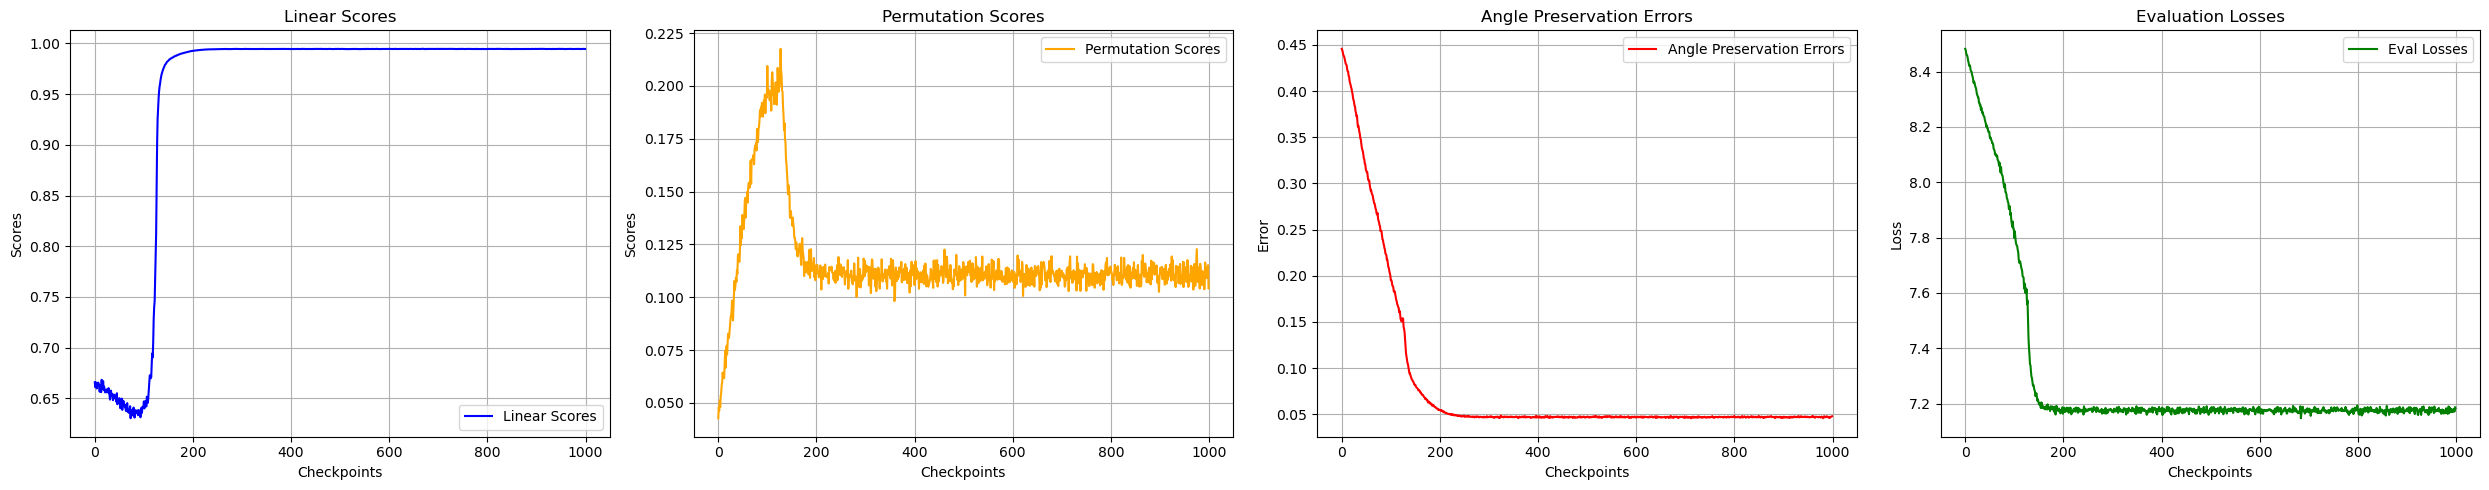

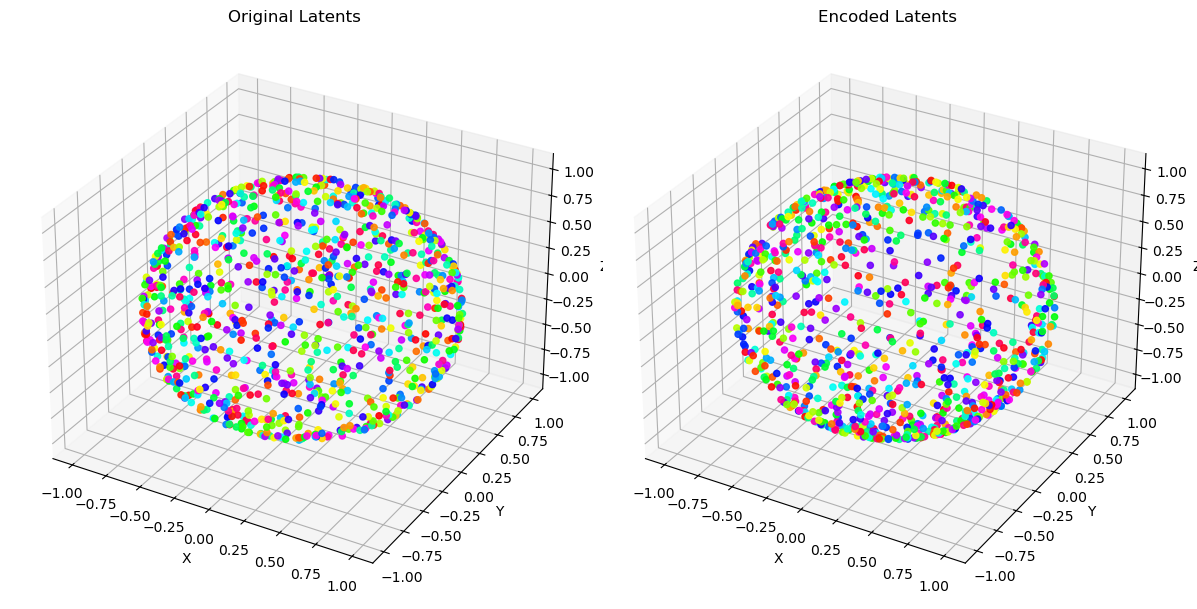

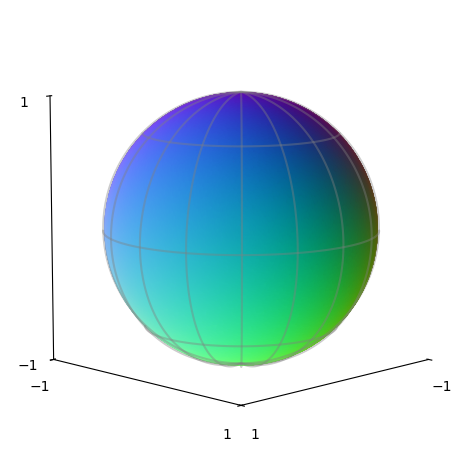

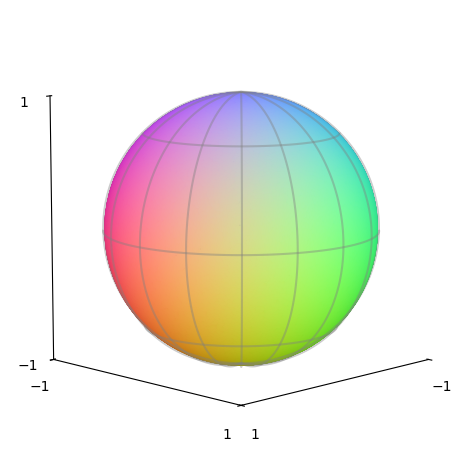

In [27]:
from experiment_utils.linear import perform_linear_experiment

f_linear_constrained = LinearEncoder(4, 3)

h, scores = perform_linear_experiment(
    4, 20000, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device, f_linear_constrained
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

z = full_sphere.uniform(100000)

fig = scatter3d_sphere(plt, z.cpu(), h(z.to(device)).cpu(), s=10, a=.8)
fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)

In [28]:
print("Orhtogonal loss:", compute_orthogonal_transformation_loss(sample_pair_fixed))
print("Training loss", scores['eval_losses'][-1])


Orhtogonal loss: 7.192995071411133
Training loss 7.183254241943359


Linear control score: 1.0
Permutation control score: 0.9999999999999999
Loss: 7.884661674499512 Samples processed: 1 linear disentanglement: 0.34453311562538147 permutation disentanglement: 0.16744934022426605 angle_preservation_error: 0.2657564878463745
Loss: 7.180846691131592 Samples processed: 21 linear disentanglement: 0.5647785067558289 permutation disentanglement: 0.20316189527511597 angle_preservation_error: 0.21653249859809875
Loss: 7.053160667419434 Samples processed: 41 linear disentanglement: 0.43853759765625 permutation disentanglement: 0.13079072535037994 angle_preservation_error: 0.2507902681827545
Loss: 6.983062744140625 Samples processed: 61 linear disentanglement: 0.3372909128665924 permutation disentanglement: 0.12000264972448349 angle_preservation_error: 0.2728841006755829
Loss: 6.957527160644531 Samples processed: 81 linear disentanglement: 0.316680908203125 permutation disentanglement: 0.11888930946588516 angle_preservation_error: 0.2777591347694397
Loss: 6.9526572

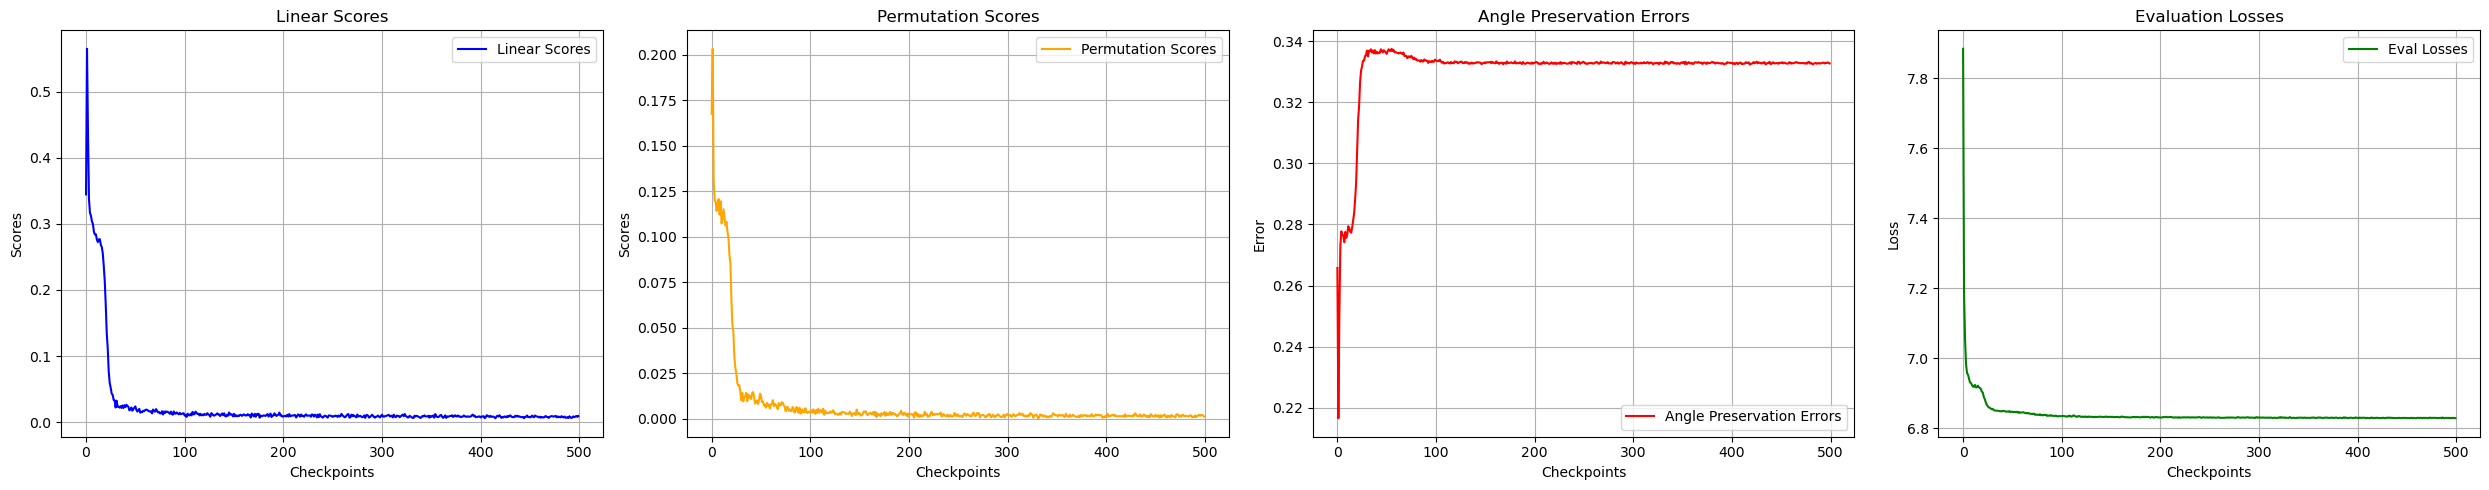

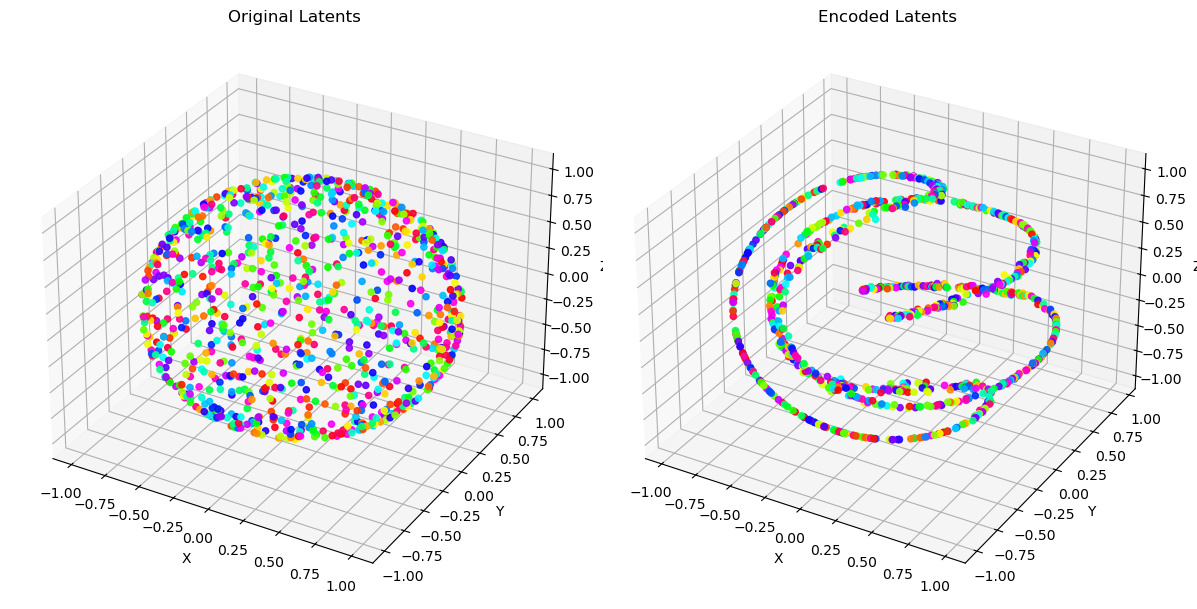

Orhtogonal loss: 7.193511486053467
Training loss 6.8284010887146


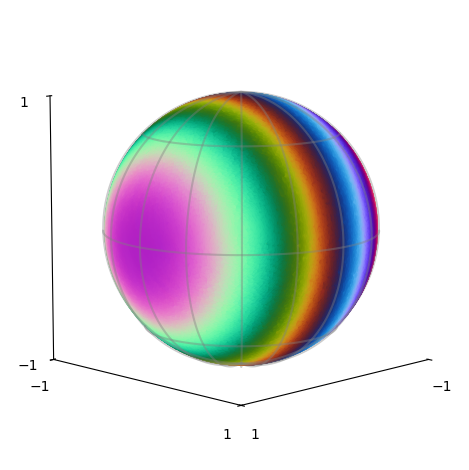

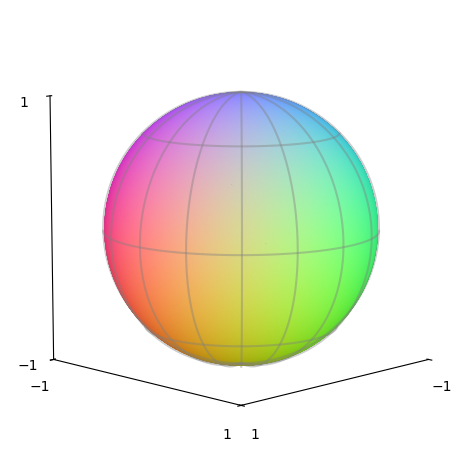

In [32]:
from encoders import SphericalEncoder
from experiment_utils.linear import perform_linear_experiment

f_constrained = SphericalEncoder(input_dim=4, output_dim=3)

h, scores = perform_linear_experiment(
    4, 10000, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device, f_constrained
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

z = full_sphere.uniform(100000)

fig = scatter3d_sphere(plt, z.cpu(), h(z.to(device)).cpu(), s=10, a=.8)
fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)

print("Orhtogonal loss:", compute_orthogonal_transformation_loss(sample_pair_fixed))
print("Training loss", scores['eval_losses'][-1])

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.973092555999756 Samples processed: 1 linear disentanglement: 0.6621156334877014 permutation disentanglement: 0.1001976728439331 angle_preservation_error: 0.26104047894477844
Loss: 7.964780330657959 Samples processed: 21 linear disentanglement: 0.6675651669502258 permutation disentanglement: 0.10602843761444092 angle_preservation_error: 0.2573779225349426
Loss: 7.93428373336792 Samples processed: 41 linear disentanglement: 0.6742027401924133 permutation disentanglement: 0.10252394527196884 angle_preservation_error: 0.2497878074645996
Loss: 7.949604034423828 Samples processed: 61 linear disentanglement: 0.6694515347480774 permutation disentanglement: 0.10723390430212021 angle_preservation_error: 0.24877142906188965
Loss: 7.944126129150391 Samples processed: 81 linear disentanglement: 0.6798932552337646 permutation disentanglement: 0.10953905433416367 angle_preservation_error: 0.2490270435810089
Loss: 7.926958084106445 Sampl

Loss: 7.749716758728027 Samples processed: 441 linear disentanglement: 0.8025786876678467 permutation disentanglement: 0.12447712570428848 angle_preservation_error: 0.20056606829166412
Loss: 7.750038146972656 Samples processed: 461 linear disentanglement: 0.8236465454101562 permutation disentanglement: 0.12740100920200348 angle_preservation_error: 0.200898215174675
Loss: 7.73335599899292 Samples processed: 481 linear disentanglement: 0.817923367023468 permutation disentanglement: 0.12404531240463257 angle_preservation_error: 0.19807952642440796
Loss: 7.7196478843688965 Samples processed: 501 linear disentanglement: 0.8361760973930359 permutation disentanglement: 0.120572030544281 angle_preservation_error: 0.19442060589790344
Loss: 7.707082271575928 Samples processed: 521 linear disentanglement: 0.8502072691917419 permutation disentanglement: 0.12396720796823502 angle_preservation_error: 0.19110740721225739
Loss: 7.712846279144287 Samples processed: 541 linear disentanglement: 0.8471937

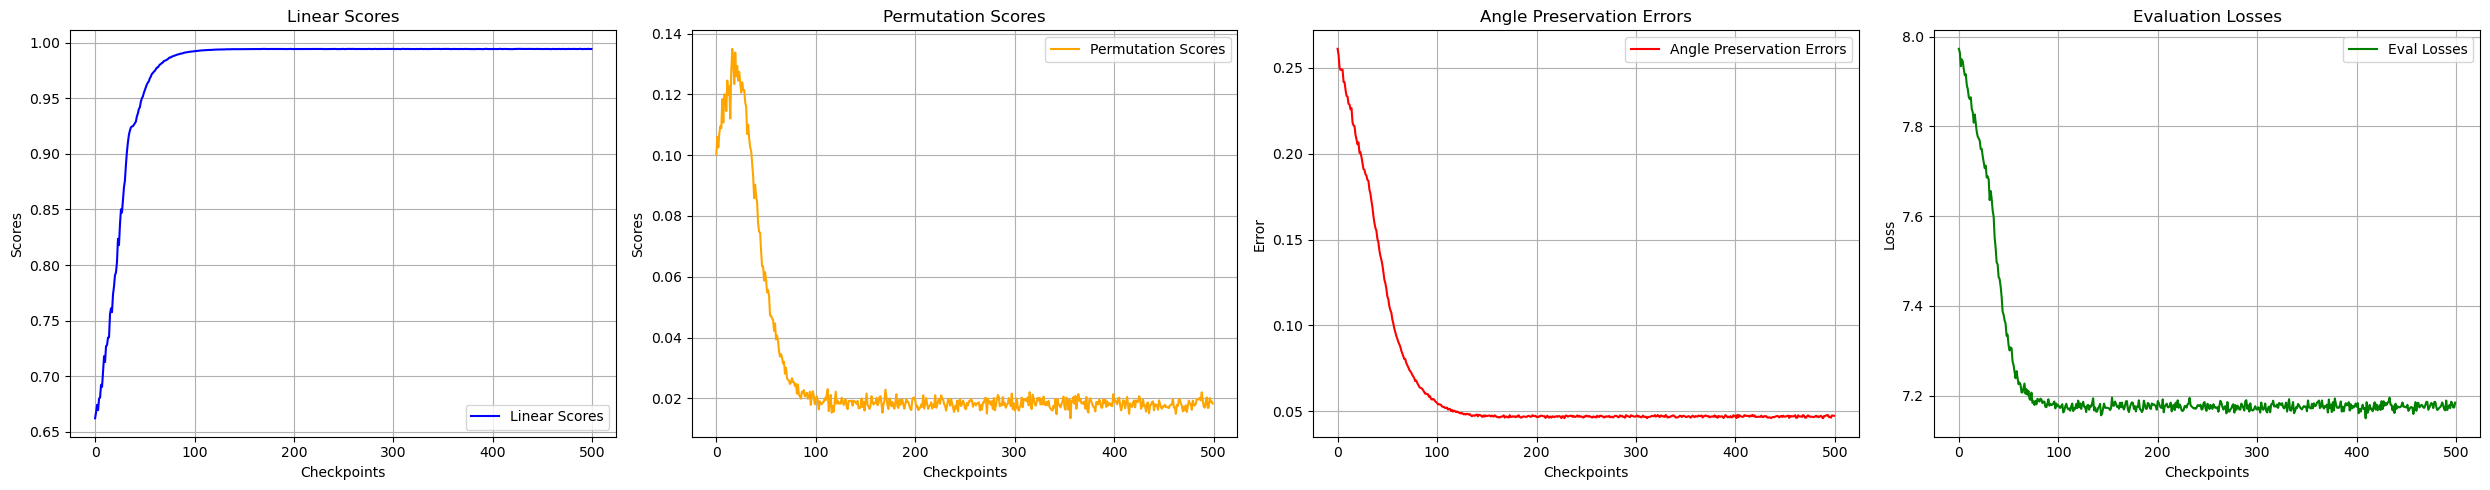

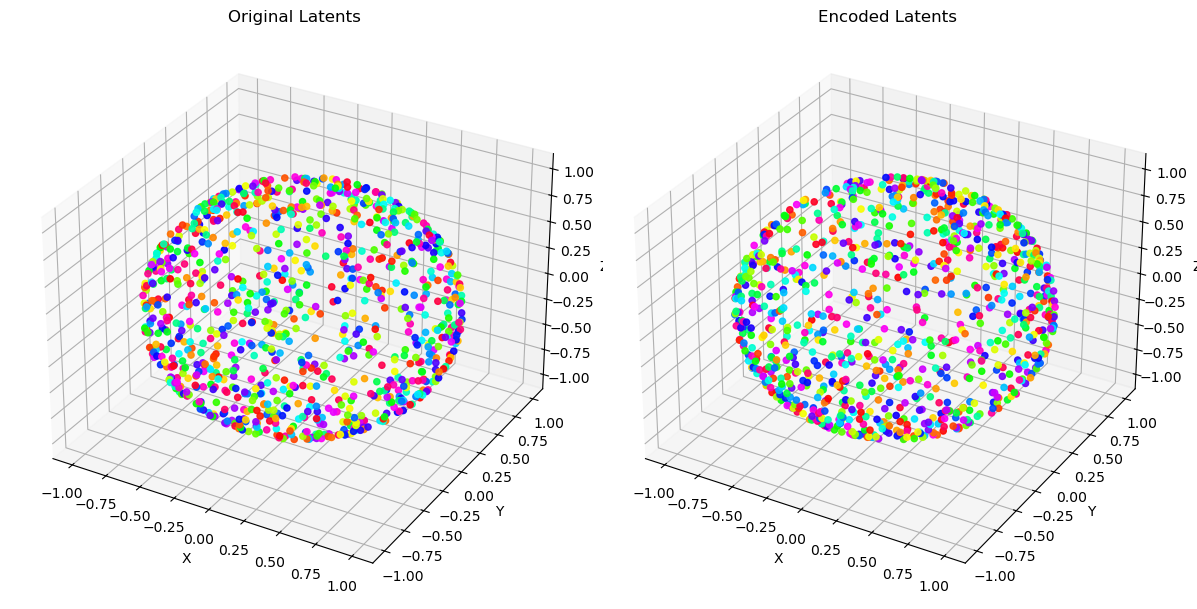

Orhtogonal loss: 7.193963050842285
Training loss 7.184426784515381


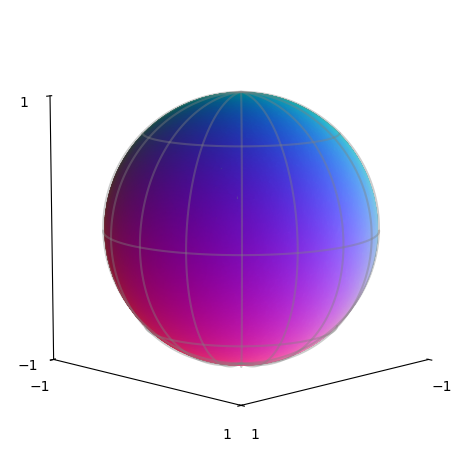

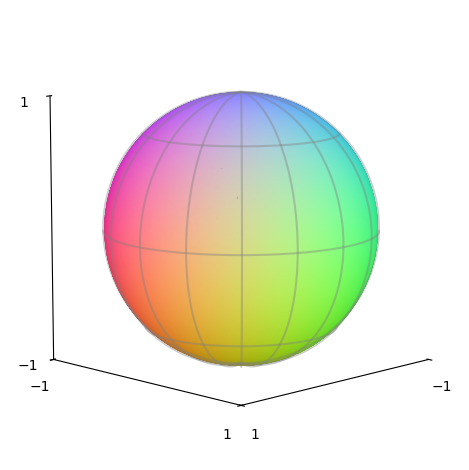

In [33]:
from experiment_utils.linear import perform_linear_experiment

f_linear_constrained = LinearEncoder(5, 3)

h, scores = perform_linear_experiment(
    5, iterations , batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device, f=f_linear_constrained
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

z = full_sphere.uniform(100000)

fig = scatter3d_sphere(plt, z.cpu(), h(z.to(device)).cpu(), s=10, a=.8)
fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)

print("Orhtogonal loss:", compute_orthogonal_transformation_loss(sample_pair_fixed))
print("Training loss", scores['eval_losses'][-1])

In [35]:
print(compute_orthogonal_transformation_loss(sample_pair_fixed))
print("Training loss", scores['eval_losses'][-1])

7.204527854919434
Training loss 7.184426784515381


Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.780572891235352 Samples processed: 1 linear disentanglement: 0.8630048632621765 permutation disentanglement: 0.38616445660591125 angle_preservation_error: 0.20663435757160187
Loss: 7.756803035736084 Samples processed: 21 linear disentanglement: 0.869548499584198 permutation disentanglement: 0.3955751955509186 angle_preservation_error: 0.20406675338745117
Loss: 7.750967025756836 Samples processed: 41 linear disentanglement: 0.8705838322639465 permutation disentanglement: 0.3879890441894531 angle_preservation_error: 0.204375222325325
Loss: 7.734185218811035 Samples processed: 61 linear disentanglement: 0.8729127049446106 permutation disentanglement: 0.38697633147239685 angle_preservation_error: 0.20100967586040497
Loss: 7.730838298797607 Samples processed: 81 linear disentanglement: 0.8739182353019714 permutation disentanglement: 0.40093159675598145 angle_preservation_error: 0.19730804860591888
Loss: 7.7101054191589355 Samp

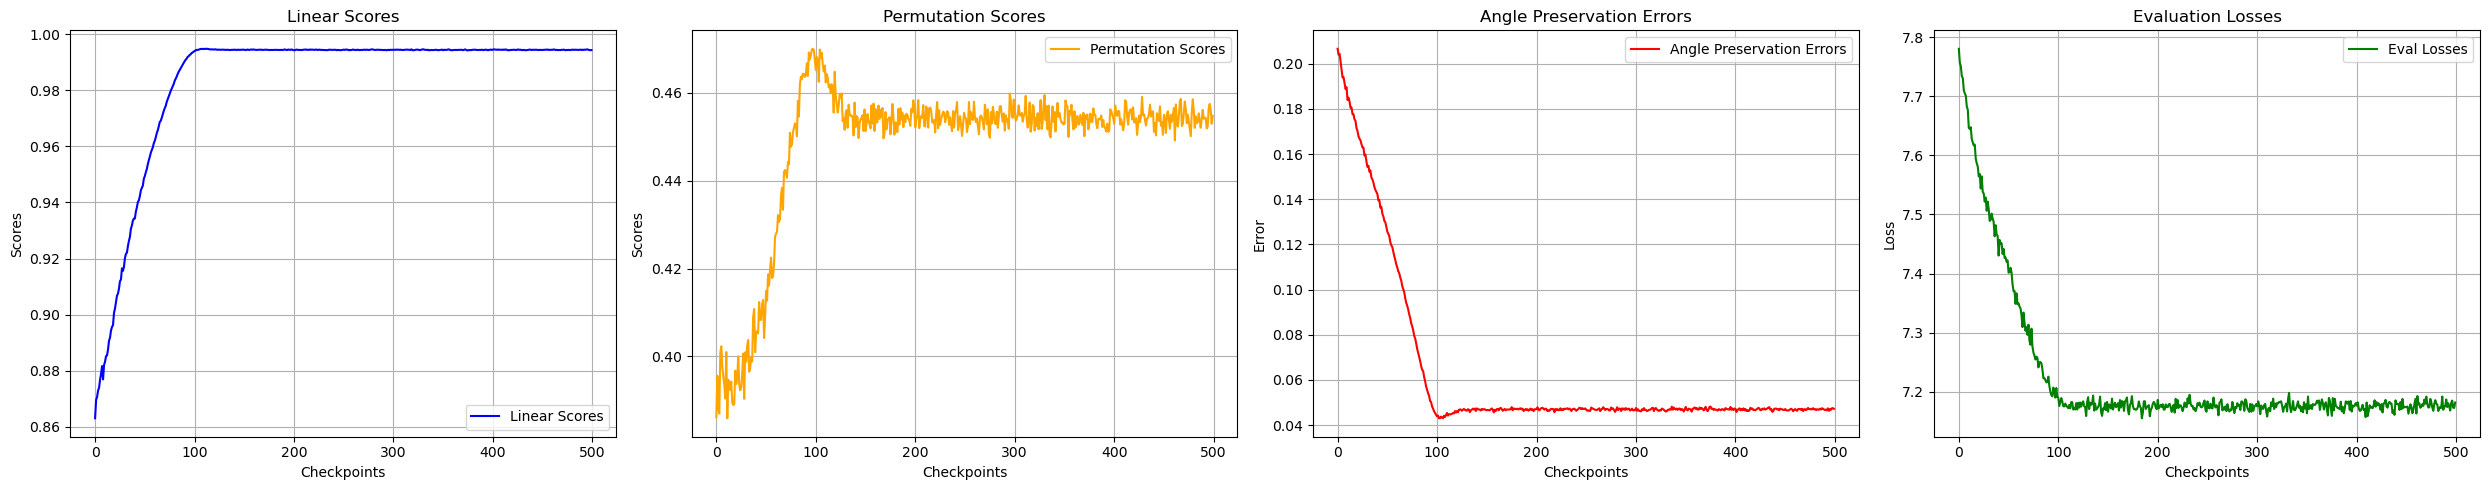

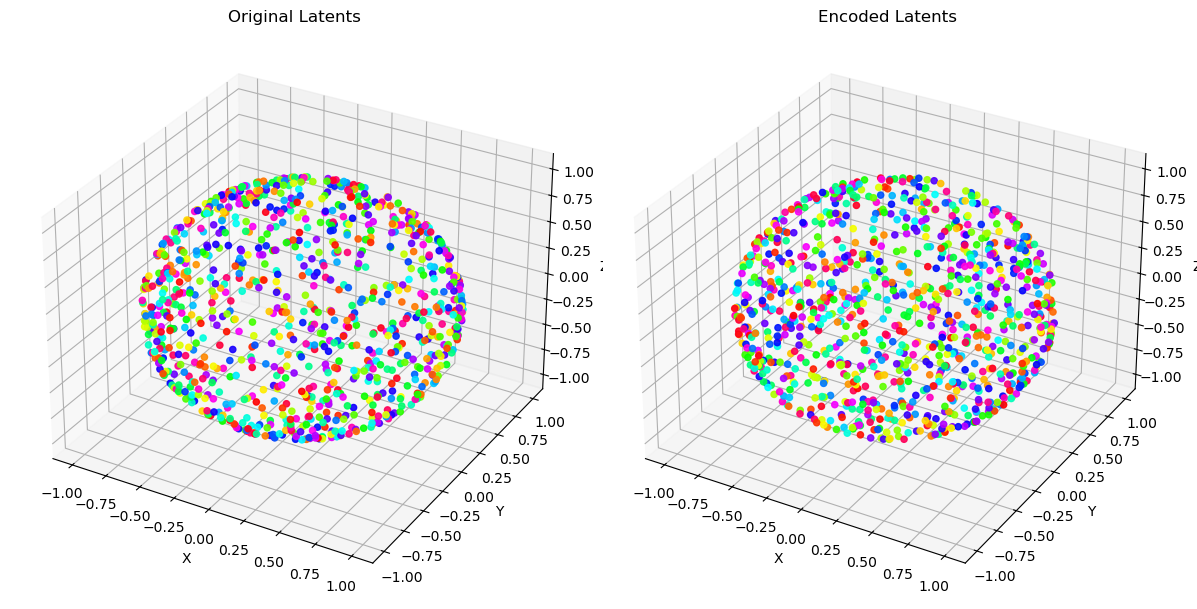

In [27]:
from experiment_utils.linear import perform_linear_experiment

f_linear_constrained = LinearEncoder(6, 3)

h, scores = perform_linear_experiment(
    6, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device, f=f_linear_constrained
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

z = full_sphere.uniform(100000)

fig = scatter3d_sphere(plt, z.cpu(), h(z.to(device)).cpu(), s=10, a=.8)
fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)

print("Orhtogonal loss:", compute_orthogonal_transformation_loss(sample_pair_fixed))
print("Training loss", scores['eval_losses'][-1])

In [37]:
print(compute_orthogonal_transformation_loss(sample_pair_fixed))
print("Training loss", scores['eval_losses'][-1])

7.182507514953613
Training loss 7.184426784515381


Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.775391578674316 Samples processed: 1 linear disentanglement: 0.8759605884552002 permutation disentanglement: 0.33555737137794495 angle_preservation_error: 0.20421142876148224
Loss: 7.752501487731934 Samples processed: 21 linear disentanglement: 0.8789463639259338 permutation disentanglement: 0.3341192901134491 angle_preservation_error: 0.20038843154907227
Loss: 7.749597072601318 Samples processed: 41 linear disentanglement: 0.8828509449958801 permutation disentanglement: 0.34809064865112305 angle_preservation_error: 0.19428043067455292
Loss: 7.738109111785889 Samples processed: 61 linear disentanglement: 0.8892216682434082 permutation disentanglement: 0.3388789892196655 angle_preservation_error: 0.19558650255203247
Loss: 7.718062400817871 Samples processed: 81 linear disentanglement: 0.8903719782829285 permutation disentanglement: 0.3576008081436157 angle_preservation_error: 0.19124668836593628
Loss: 7.720815181732178 Sam

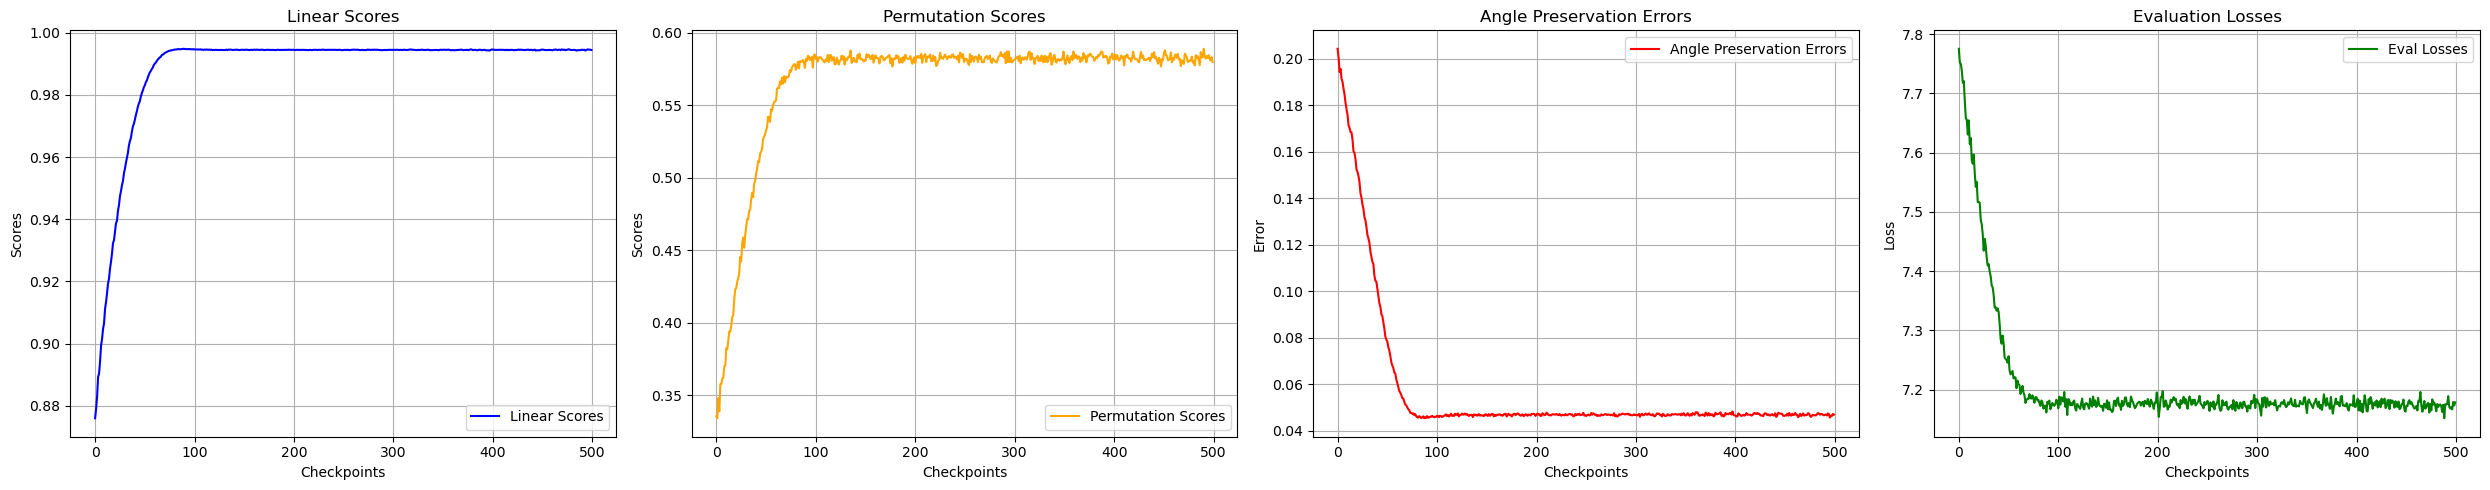

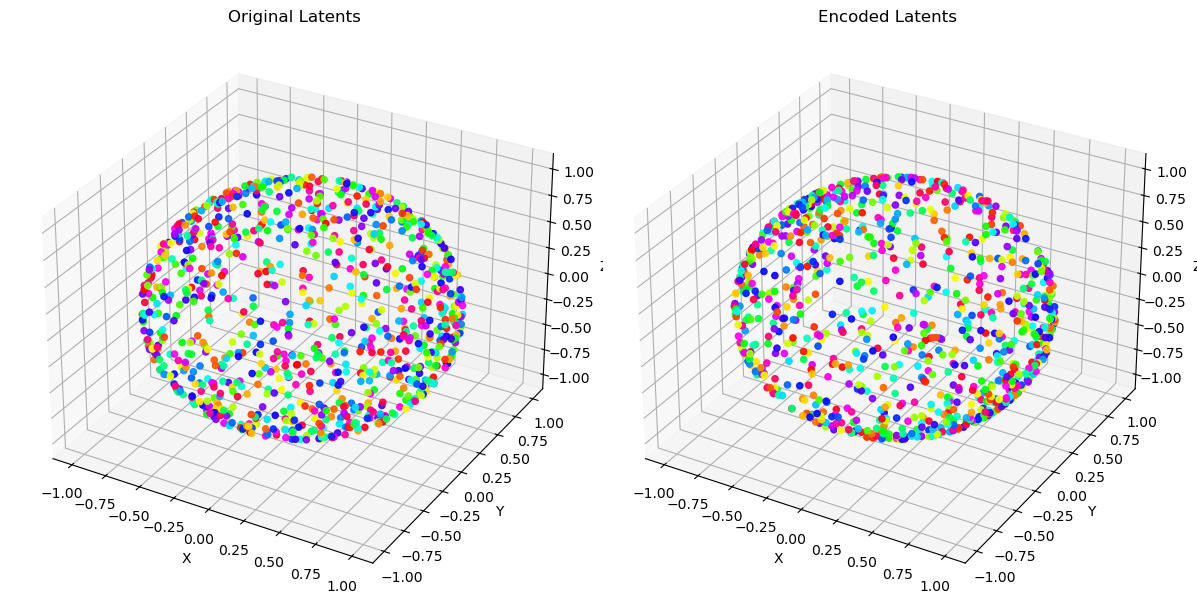

Orhtogonal loss: 7.196061134338379
Training loss 7.178399562835693


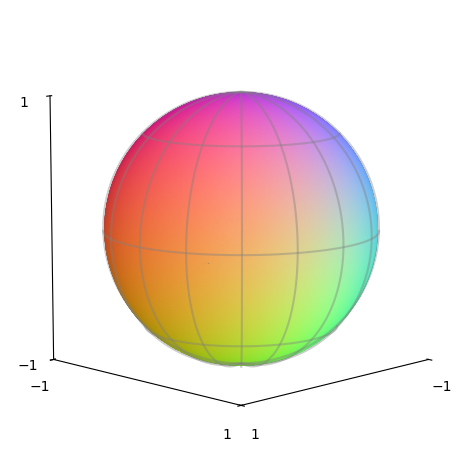

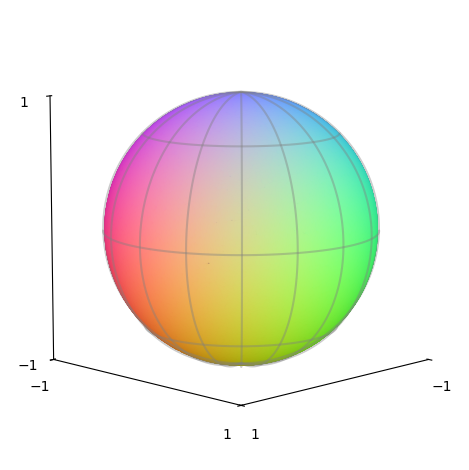

In [38]:
from experiment_utils.linear import perform_linear_experiment

f_linear_constrained = LinearEncoder(7, 3)

h, scores = perform_linear_experiment(
    7, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device, f=f_linear_constrained
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

z = full_sphere.uniform(100000)

fig = scatter3d_sphere(plt, z.cpu(), h(z.to(device)).cpu(), s=10, a=.8)
fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)

print("Orhtogonal loss:", compute_orthogonal_transformation_loss(sample_pair_fixed))
print("Training loss", scores['eval_losses'][-1])

In [39]:
print(compute_orthogonal_transformation_loss(sample_pair_fixed))
print("Training loss", scores['eval_losses'][-1])

7.1952667236328125
Training loss 7.178399562835693


## Spiral generating process

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.933540344238281 Samples processed: 1 linear disentanglement: 0.2022925615310669 permutation disentanglement: 0.02870641089975834 angle_preservation_error: 0.28443774580955505
Loss: 8.093242645263672 Samples processed: 21 linear disentanglement: 0.33294689655303955 permutation disentanglement: 0.019549569115042686 angle_preservation_error: 0.2516714036464691
Loss: 7.8790082931518555 Samples processed: 41 linear disentanglement: 0.4031287729740143 permutation disentanglement: 0.030864238739013672 angle_preservation_error: 0.24308712780475616
Loss: 7.7155866622924805 Samples processed: 61 linear disentanglement: 0.4903474748134613 permutation disentanglement: 0.03606327250599861 angle_preservation_error: 0.21679015457630157
Loss: 7.647990703582764 Samples processed: 81 linear disentanglement: 0.5523450970649719 permutation disentanglement: 0.04248221591114998 angle_preservation_error: 0.19850307703018188
Loss: 7.588349342346

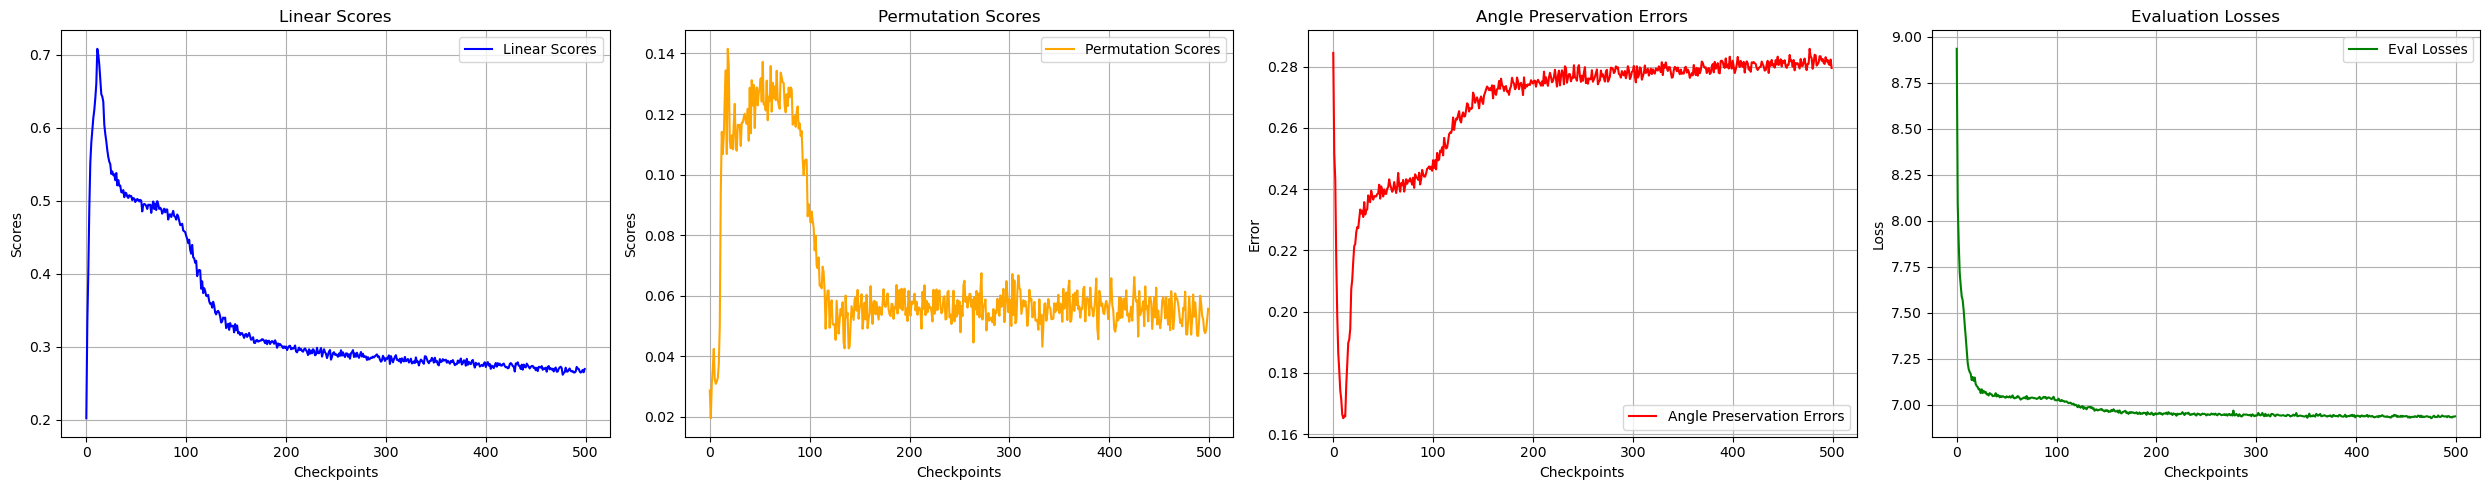

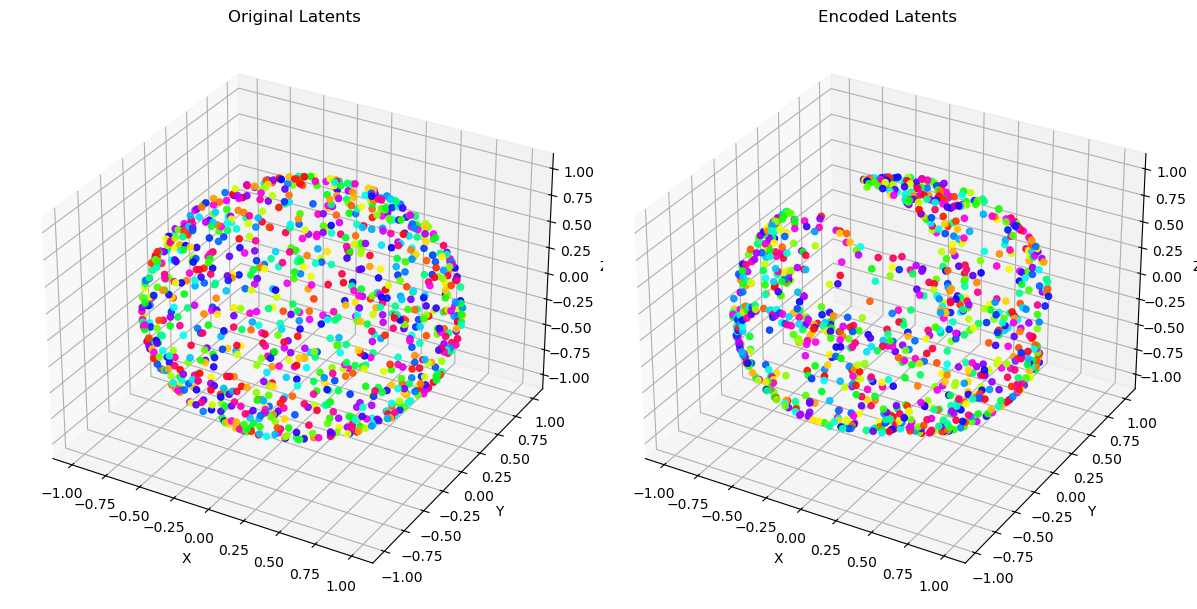

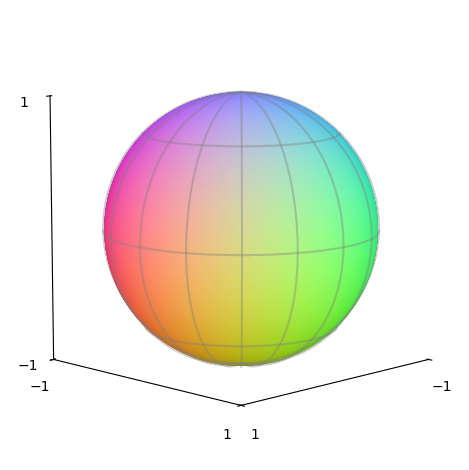

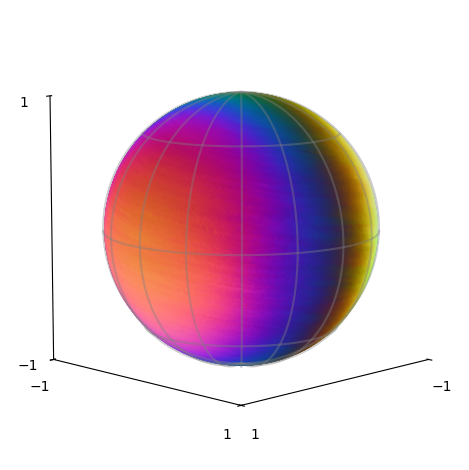

In [40]:
# from visualization_utils.scoring import plot_scores
from visualization_utils.spheres import scatter3d_sphere

from data.generation import SpiralRotation
from encoders import SphericalEncoder

f_spiral = SphericalEncoder(input_dim=3, hidden_dims=[128, 256, 128], output_dim=3)

g_spiral = SpiralRotation(2)

simclr_spiral = SimCLR(
    f_spiral, g_spiral, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_spiral, scores = simclr_spiral.train(batch_size, iterations)

plot_scores(plt, scores)

h_spiral = lambda z: f_spiral(g_spiral(z))

z = full_sphere.uniform(1000).to(device)
z_enc = h_spiral(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

z = full_sphere.uniform(100000).to(device)
z_enc = h_spiral(z).to(device)

fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)
fig = scatter3d_sphere(plt, z.cpu(), h_spiral(z).cpu(), s=10, a=.8)

In [41]:
print("Orthogonal transform loss:", compute_orthogonal_transformation_loss(sample_pair_fixed))
print("Training loss", scores['eval_losses'][-1])

Orthogonal transform loss: 7.193347930908203
Training loss 6.937338829040527


## Patched generating process

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.259481430053711 Samples processed: 1 linear disentanglement: 0.3164668679237366 permutation disentanglement: 0.05913976952433586 angle_preservation_error: 0.26389235258102417
Loss: 7.432412147521973 Samples processed: 21 linear disentanglement: 0.7928608059883118 permutation disentanglement: 0.16201217472553253 angle_preservation_error: 0.13934877514839172
Loss: 7.3503875732421875 Samples processed: 41 linear disentanglement: 0.8725113272666931 permutation disentanglement: 0.15783844888210297 angle_preservation_error: 0.11291498690843582
Loss: 7.294686794281006 Samples processed: 61 linear disentanglement: 0.8876356482505798 permutation disentanglement: 0.16784746944904327 angle_preservation_error: 0.10525378584861755
Loss: 7.289506435394287 Samples processed: 81 linear disentanglement: 0.8973477482795715 permutation disentanglement: 0.1662067025899887 angle_preservation_error: 0.10125203430652618
Loss: 7.281384468078613 

Loss: 7.137407302856445 Samples processed: 1721 linear disentanglement: 0.5653834939002991 permutation disentanglement: 0.16894739866256714 angle_preservation_error: 0.21453048288822174
Loss: 7.145054817199707 Samples processed: 1741 linear disentanglement: 0.5742571949958801 permutation disentanglement: 0.17852811515331268 angle_preservation_error: 0.21140171587467194
Loss: 7.141800880432129 Samples processed: 1761 linear disentanglement: 0.5634588599205017 permutation disentanglement: 0.1661006212234497 angle_preservation_error: 0.21368151903152466
Loss: 7.132589340209961 Samples processed: 1781 linear disentanglement: 0.5622929930686951 permutation disentanglement: 0.17030905187129974 angle_preservation_error: 0.2149764448404312
Loss: 7.150650978088379 Samples processed: 1801 linear disentanglement: 0.5665815472602844 permutation disentanglement: 0.16909749805927277 angle_preservation_error: 0.2118268609046936
Loss: 7.130965232849121 Samples processed: 1821 linear disentanglement: 0

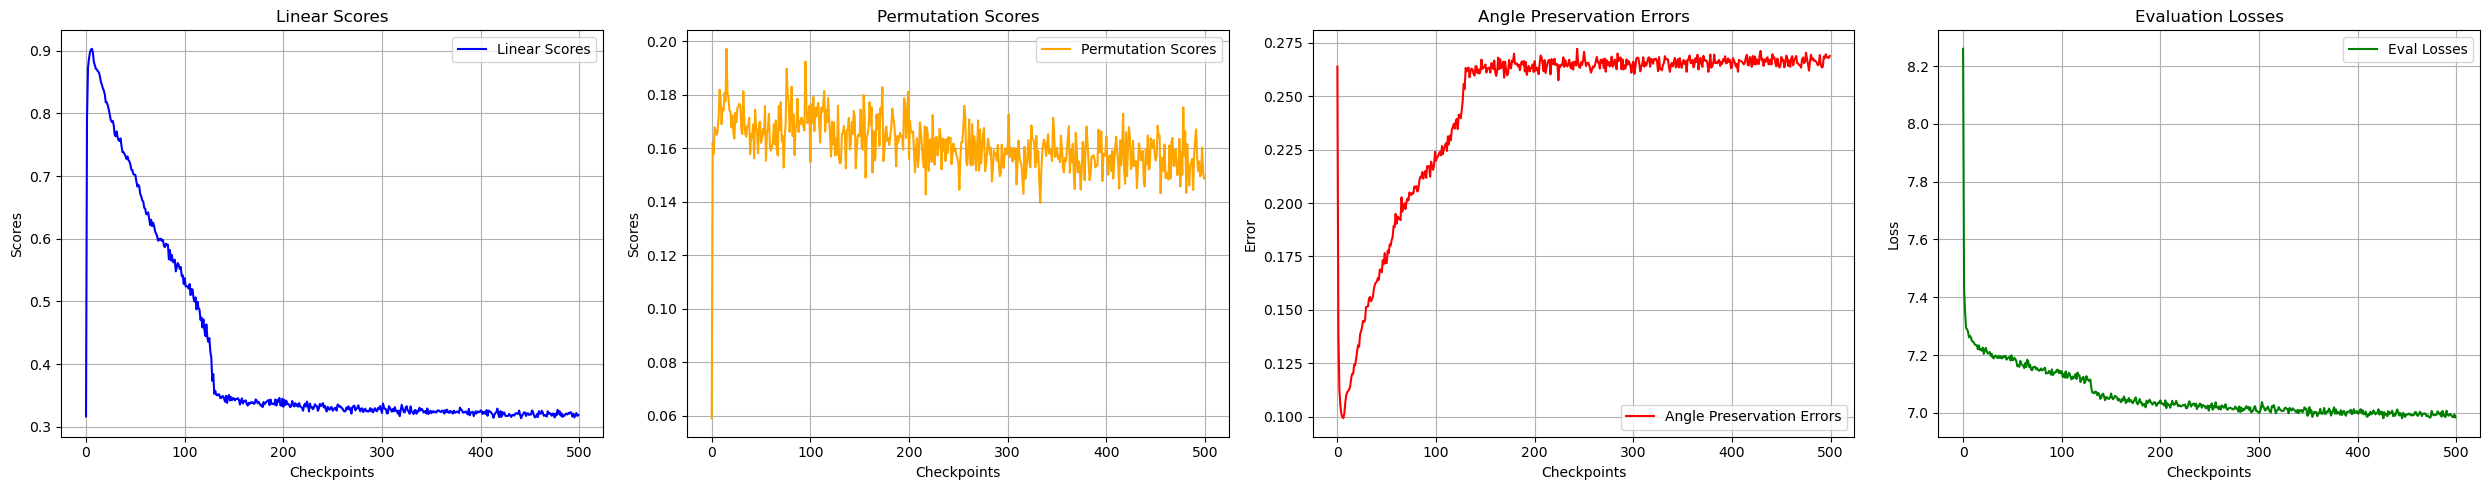

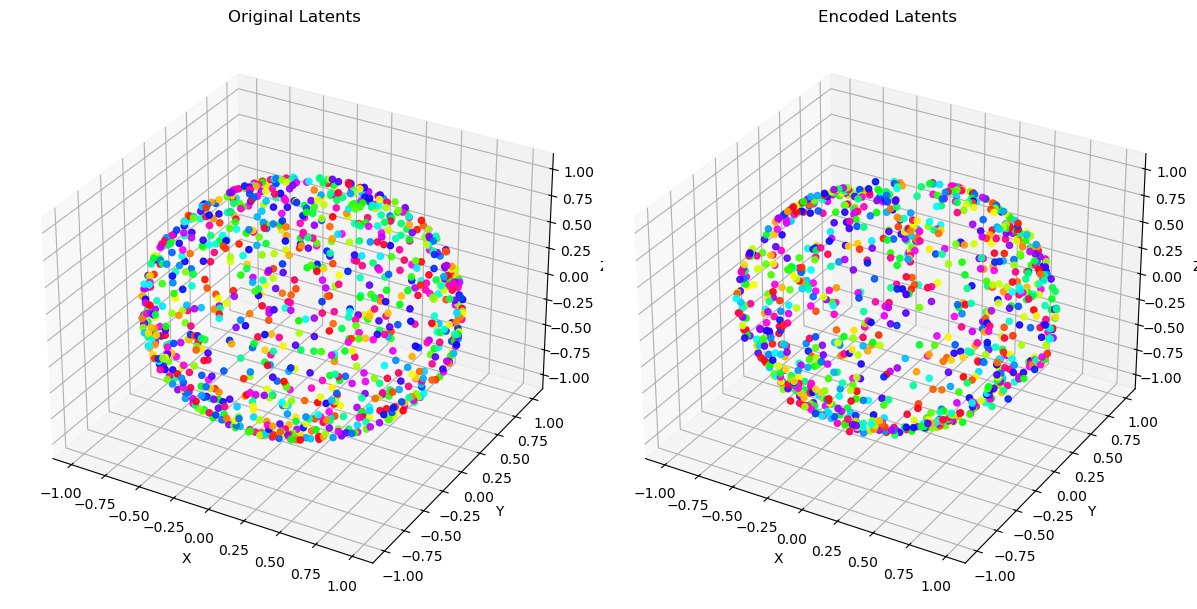

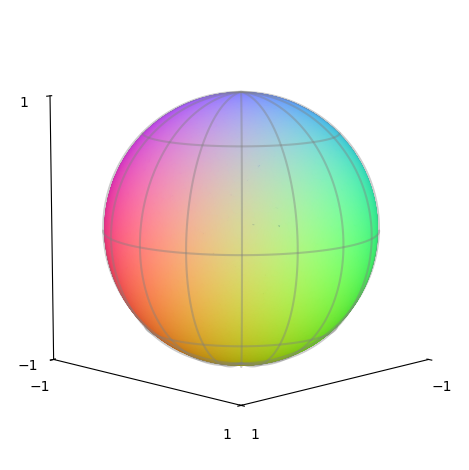

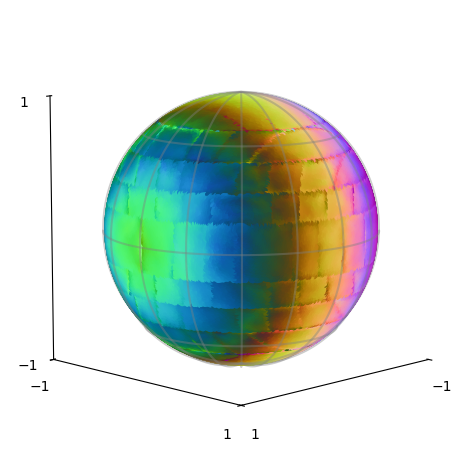

In [42]:
from visualization_utils.spheres import scatter3d_sphere
from visualization_utils.scoring import plot_scores

from data.generation import Patches

from encoders import SphericalEncoder

g_patches = Patches(5, device)
f_patches = SphericalEncoder(input_dim=3, hidden_dims=[128, 256, 128], output_dim=3)

simclr_patches = SimCLR(
    f_patches, g_patches, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_patches, scores = simclr_patches.train(batch_size, iterations)

plot_scores(plt, scores)

h_patches = lambda z: f_patches(g_patches(z))

z = full_sphere.uniform(1000).to(device)
z_enc = h_patches(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

z = full_sphere.uniform(100000).to(device)
z_enc = h_patches(z).to(device)

fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)
fig = scatter3d_sphere(plt, z.cpu(), h_patches(z).cpu(), s=10, a=.8)

In [44]:
print("Orhtogonal loss:", compute_orthogonal_transformation_loss(sample_pair_fixed))
print("Training loss", scores['eval_losses'][-1])

Orhtogonal loss: 7.200254440307617
Training loss 6.984664440155029


## Experiment with the invertible MLP as a data generating process

condition number threshold: 1.036139
layer 1/3,  condition number: 1.0340533370039544
layer 2/3,  condition number: 1.0336129747216005
layer 3/3,  condition number: 1.035489669568872


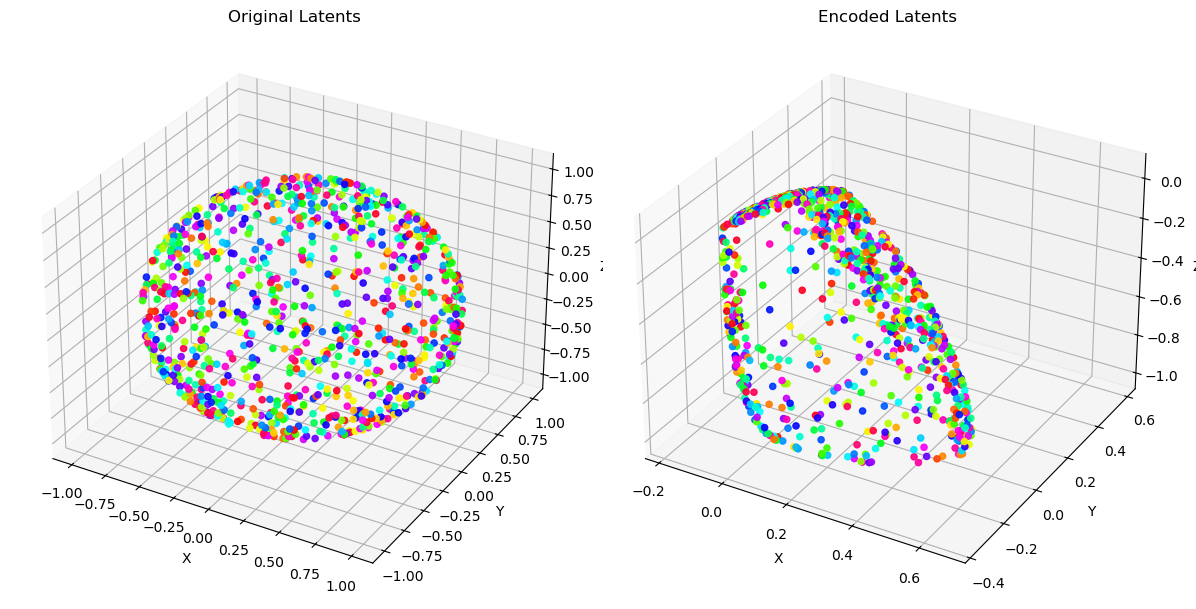

In [45]:
from invertible_network_utils import construct_invertible_mlp

g_mlp = construct_invertible_mlp(
        n=3,
        n_layers=3,
        act_fct='leaky_relu',
        cond_thresh_ratio=0.0,
        n_iter_cond_thresh=25000,
).to(device)

z = full_sphere.uniform(1000).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), g_mlp(z).cpu())

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.995977401733398 Samples processed: 1 linear disentanglement: 0.35602083802223206 permutation disentanglement: 0.00740822171792388 angle_preservation_error: 0.25479936599731445
Loss: 7.278109550476074 Samples processed: 21 linear disentanglement: 0.8384301066398621 permutation disentanglement: 0.056068599224090576 angle_preservation_error: 0.13690488040447235
Loss: 7.210945129394531 Samples processed: 41 linear disentanglement: 0.8927557468414307 permutation disentanglement: 0.07108545303344727 angle_preservation_error: 0.11067979782819748
Loss: 7.191946983337402 Samples processed: 61 linear disentanglement: 0.8827362656593323 permutation disentanglement: 0.07289731502532959 angle_preservation_error: 0.11424204707145691
Loss: 7.167102813720703 Samples processed: 81 linear disentanglement: 0.8059182167053223 permutation disentanglement: 0.050728101283311844 angle_preservation_error: 0.13822875916957855
Loss: 7.1636252403259

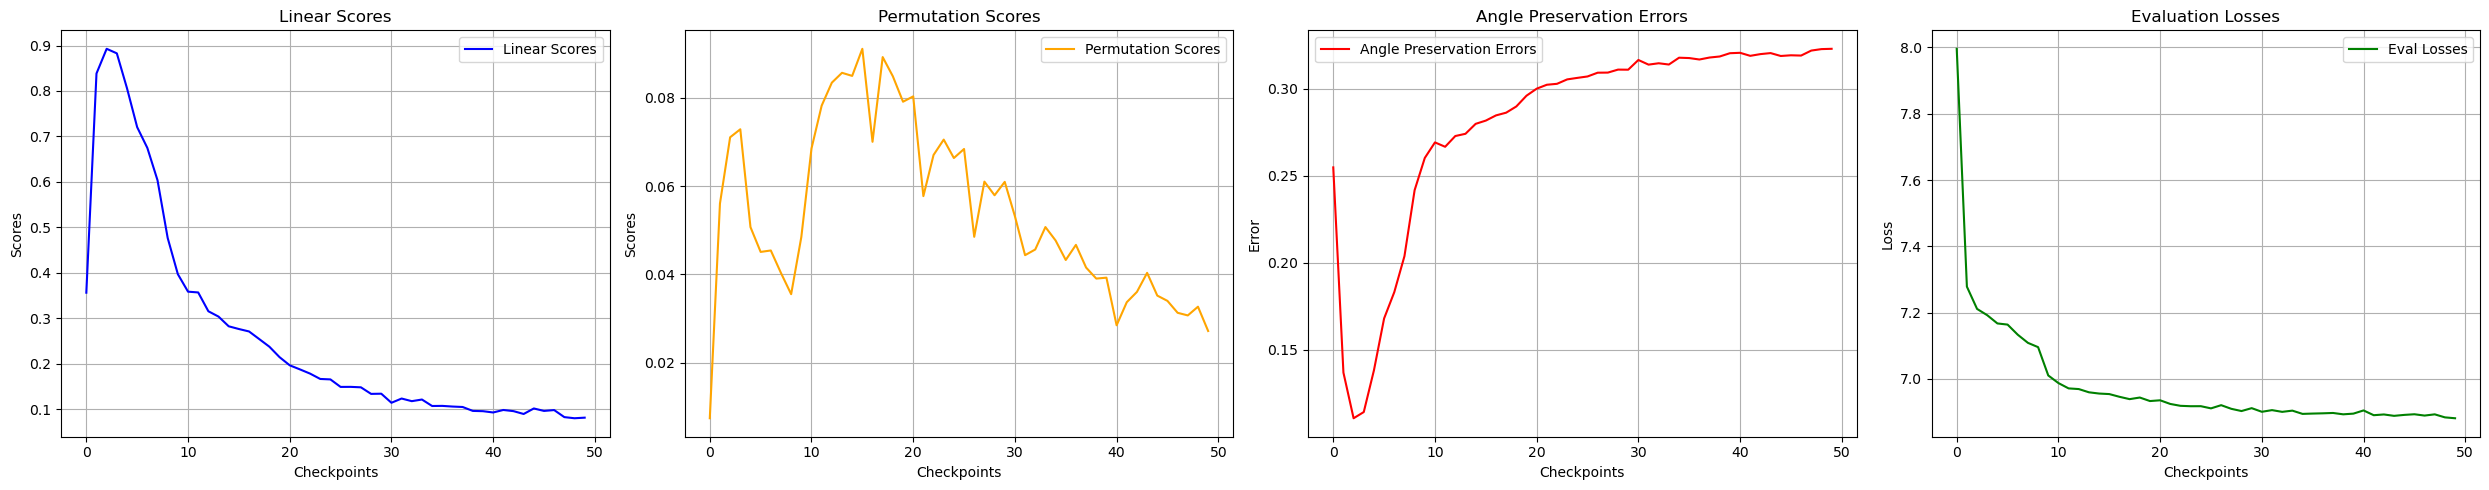

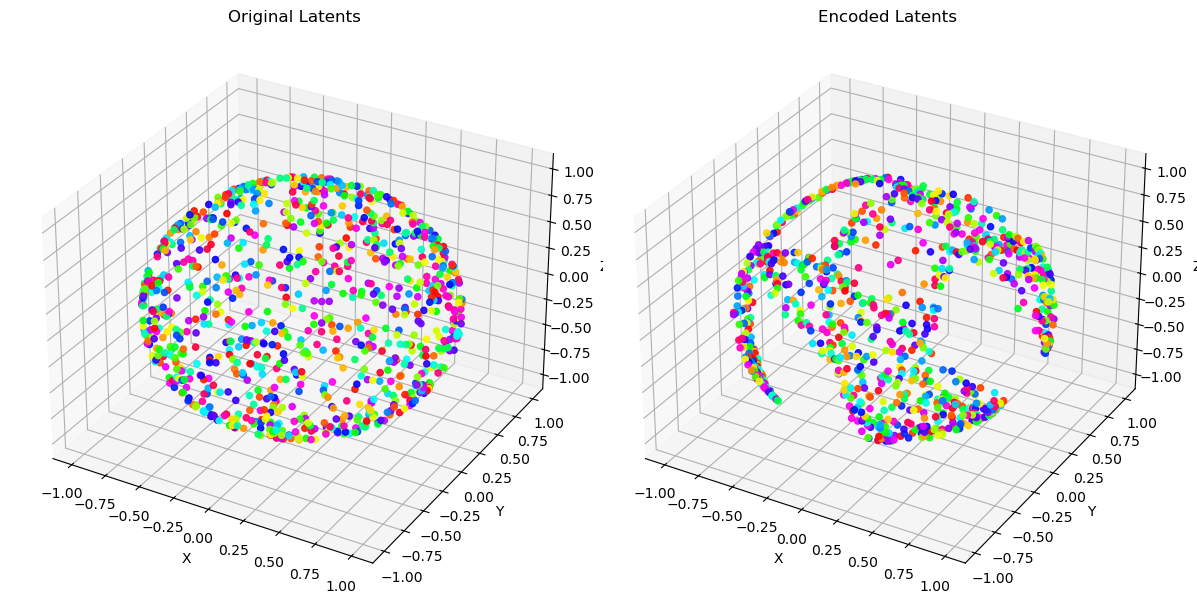

In [53]:
f_mlp = SphericalEncoder(input_dim=3, hidden_dims=[128, 256, 128], output_dim=3).to(device)

simclr_mlp = SimCLR(
    f_mlp, g_mlp, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_mlp, scores = simclr_mlp.train(batch_size, 1000)

plot_scores(plt, scores)

h_mlp = lambda latent: f_mlp(g_mlp(latent))

z = full_sphere.uniform(1000).to(device)
z_enc = h_mlp(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

In [54]:
print("Orhtogonal loss:", compute_orthogonal_transformation_loss(sample_pair_fixed))
print("Training loss", scores['eval_losses'][-1])

Orhtogonal loss: 7.1919097900390625
Training loss 6.8809638023376465


In [52]:
min([compute_orthogonal_transformation_loss(sample_pair_fixed) for _ in range(10)])

7.191295623779297

## Next

- Run it with a correct model (Cross-Entropy with a correct normalizer)